In [1]:
## Import required tools, don't need to edit.
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from pandas.core.common import random_state
import numpy as np
from scipy.stats import norm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GroupKFold, cross_val_score, GroupShuffleSplit
from sklearn.model_selection import KFold as kf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR #Support Vector Regressor

import joblib  
# import shap
import os
import itertools
import random
from datetime import datetime

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import mordred
from mordred import Calculator, descriptors

# from ibug import IBUGWrapper

## Calculate copolymer descriptors

Load and prepare datasets for copolymer composition and monomer descriptors. Must use mol% of monomers in copolymers

In [2]:
"""
Need to set up some parameters at the start, to ensure code functions, and data is exported uniquely and to a defined location.
Define the monomers in your experimental polymer library. Will be called for setting up dataframe and calculating copolymer descriptors.
Define the name of the experiment to create a working directory for the experiment and to ensure all output files are uniquely labelled, 
but can be linked to common experiment.
Define where you want your data outputs to be saved. Will create the folder, if it doesn't exist already
Go to cell highlighted with ************ to define descriptor library you want to use
"""
#Define monomers in experimental polymers. Need to match exactly to your monomer descriptor library.
mono_head = ['Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)',
             'Triethylene glycol methyl ether methacrylate',
             'Dodecyl Methacrylate',
             'Benzyl Methacrylate',
             '2-(Dimethylamino)ethyl Methacrylate',
             '2-(Diethylamino)ethyl Methacrylate',
             '2-(Diisopropylamino)ethyl Methacrylate',
             '3-Sulfopropyl Methacrylate',
             '3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate',
             '2-Methacryloyloxyethyl phosphorylcholine'
            ] 

#Provide a date and experiment name for labelling polymers. Automatically sets the date for the date that this cell is run.
expt_date = datetime.now().strftime("%Y%m%d")
expt_name = f'{expt_date}_antiviral polym_AL'

# Define the desired directory path for outputing files
# desired_directory = f'ML_polymers/{expt_name}'
desired_directory = f'ML_polymers/20250107_antiviral polym_AL'
# Create the directory if it doesn't exist
if not os.path.exists(desired_directory):
    os.makedirs(desired_directory)

# Change the current working directory to the desired path
os.chdir(desired_directory)

# Confirm the change
print("Current Working Directory:", os.getcwd())


Current Working Directory: /Users/quynhnguyen/ML_polymers/20250107_antiviral polym_AL


In [3]:
"""
Import data from an Excel file to a Pandas Dataframe. Need to update file location if you change the file you want to use
Header function prints top of table to quickly check data import.
Need to change '.red_excel' if data is in a different format, eg. CSV.
"""

polymers = pd.read_excel('/Users/quynhnguyen/20241021_Polymers for ML with Descriptors.xlsx')
polymers.head()

,Lab Book Code,Group,Sample,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,% Infectivity,SD % infectivity
0,A0353_124_1A-D,187,1,100.000000,0,0,0,0,0.0,0.0,0,0,0.000000,88.032787,12.488102
1,A0353_124_2A-D,187,2,94.650165,0,0,0,0,0.0,0.0,0,0,5.349835,87.704918,6.661065
2,A0353_124_3A-D,187,3,89.339587,0,0,0,0,0.0,0.0,0,0,10.660413,93.770492,8.017718
3,A0353_124_4A-D,187,4,84.067836,0,0,0,0,0.0,0.0,0,0,15.932164,92.459016,14.048712
4,A0353_124_5A-D,188,1,97.065151,0,2.934849,0,0,0.0,0.0,0,0,0.000000,90.163934,18.468652


In [4]:
# Create a new dataframe, with only columns for training ML model
polym_df=polymers.drop('Lab Book Code', axis=1).drop('Group', axis=1).drop('Sample', axis=1)

# Convert the monomer columns to numeric, forcing errors to NaN
polym_df[mono_head] = polym_df[mono_head].apply(pd.to_numeric, errors='coerce')

# Replace all NaN values with 0. Deals with issues from copy and paste from different excel files.
polym_df.fillna(0, inplace=True)

polym_df.info()
polym_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 12 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)   263 non-null    float64
 1   Triethylene glycol methyl ether methacrylate                      263 non-null    float64
 2   Dodecyl Methacrylate                                              263 non-null    float64
 3   Benzyl Methacrylate                                               263 non-null    float64
 4   2-(Dimethylamino)ethyl Methacrylate                               263 non-null    float64
 5   2-(Diethylamino)ethyl Methacrylate                                263 non-null    float64
 6   2-(Diisopropylamino)ethyl Methacrylate                            263 non-null    float64
 7   3-Sulfopropyl Methacrylate         

,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,% Infectivity,SD % infectivity
258,38.0,0.0,0.0,0.0,0.0,21.0,18.0,0.0,0.0,23.0,31.212272,11.607051
259,50.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,25.0,63.115992,12.293388
260,39.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,24.0,44.305713,10.061902
261,40.0,0.0,11.0,0.0,0.0,0.0,25.0,0.0,0.0,24.0,89.224388,6.143324
262,30.0,0.0,10.0,0.0,0.0,0.0,36.0,0.0,0.0,23.0,70.207141,9.230735


In [5]:
"""
To automatically create sample IDs from monomer composition values in table. It will ignore monomers that have null (NaN)
values, but will label 0 values, which is useful for comparing series of compositions. eg. 0-40% DMAEMA.
"""
# Create an empty list to store the new sample IDs
new_sample_ids = []

## Iterate through the DataFrame and create new sample IDs
for index, row in polym_df.iterrows():
    sample_id_parts = []
    
    for column in mono_head: #need to make sure all monomer classes in table headings are defined
        value = row[column]
        if not pd.isna(value):
            formatted_value = int(value) if float(value).is_integer() else value
            sample_id_parts.append(f"{column}({formatted_value})")
                
    if sample_id_parts:
        sample_id = '-'.join(sample_id_parts)
        new_sample_ids.append(sample_id)
    else:
        new_sample_ids.append('NoValidData')
      

## Add the new sample IDs as a new column in the DataFrame
polym_df['Auto Sample ID'] = new_sample_ids

## Save the modified DataFrame with new sample IDs to a new CSV file. Handy in case you need to refer to these later.
polym_df.to_csv(f'{expt_name}_sample_ids.csv', index=False)  # Replace with the desired file name

#Check data import by top rows in spreadsheet. Can change number of rows in brackets.
polym_df.head()

# Count and print the number of duplicate compositions in 'Auto Sample ID' column. This is important for grouping samples in testing and training data 
# to prevent leaks between train and test.
duplicate_counts = polym_df['Auto Sample ID'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]  # Filter to get only duplicates

total_duplicates = duplicate_counts.sum()
print(f"\nTotal number of duplicate Auto Sample IDs: {total_duplicates}")

print("\nDuplicate Auto Sample IDs and their counts:")
duplicate_counts


Total number of duplicate Auto Sample IDs: 60

Duplicate Auto Sample IDs and their counts:


Auto Sample ID
Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)(0)-Triethylene glycol methyl ether methacrylate(51.60106182009383)-Dodecyl Methacrylate(9.262048332397892)-Benzyl Methacrylate(0)-2-(Dimethylamino)ethyl Methacrylate(0)-2-(Diethylamino)ethyl Methacrylate(0)-2-(Diisopropylamino)ethyl Methacrylate(0)-3-Sulfopropyl Methacrylate(38.976841069766486)-3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate(0)-2-Methacryloyloxyethyl phosphorylcholine(0)    5
Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)(0)-Triethylene glycol methyl ether methacrylate(66.50675986930291)-Dodecyl Methacrylate(9.20990023632413)-Benzyl Methacrylate(0)-2-(Dimethylamino)ethyl Methacrylate(0)-2-(Diethylamino)ethyl Methacrylate(0)-2-(Diisopropylamino)ethyl Methacrylate(0)-3-Sulfopropyl Methacrylate(24.15185290000467)-3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate(0)-2-Methacryloyloxyethyl phosphorylcholine(0)      5
Polyethylene Glycol Monomethyl 

## Undersampling intervention

In [6]:
"""
If dataset is skewed with lots of samples from only a small range of your output values, can skew the predictive power of the model.
For example, in our original antiviral polymer dataset, we had lots of samples with high levels of infectivity, and very few hits with low infectivity.
Models built on the full dataset would under estimate effective antivirals (low infectivity) as the model was biased with more high infectivity values.

## First of all, I delete all replicate compositions with infectivity >80%, as they do not add singificantly to the model.
## But I want to keep replicates of low infectivity, as these are desirable outputs and already undersampled in the dataset.
"""

# Step 1: Sort the DataFrame by 'Auto Sample ID' and '% Infectivity' to ensure consistency
polym_df = polym_df.sort_values(by=['Auto Sample ID', '% Infectivity'], ascending=[True, False])

# Step 2: Remove duplicates of 'Auto Sample ID' where '% Infectivity' > 80, keeping only the first occurrence
polym_df = polym_df[~((polym_df['% Infectivity'] > 0) & (polym_df.duplicated(subset='Auto Sample ID', keep='first')))]

# Reset the index after removing the duplicates
polym_df.reset_index(drop=True, inplace=True)

# Count and print the number of duplicate values in 'Auto Sample ID' column. This is important for grouping samples in testing and training data.
duplicate_counts = polym_df['Auto Sample ID'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]  # Filter to get only duplicates

total_duplicates = duplicate_counts.sum()
print(f"\nTotal number of duplicate Auto Sample IDs: {total_duplicates}")

print("\nDuplicate Auto Sample IDs and their counts:")
duplicate_counts



Total number of duplicate Auto Sample IDs: 0

Duplicate Auto Sample IDs and their counts:


Series([], Name: count, dtype: int64)

In [7]:
"""
Equalise the distribution of samples across the output variable using an undersampling approach. (Oversampling is an alternative approach)
Bin the data into relevant bin sizes. Count the number in each bin, then manually set how many samples per bin you want.
You can decide how to pick bin size. Can use your smallest bin size, so all are exactly equal. This risks disposing of useful data for your model.
You can play with the number and check performance on model.
In this example, I didn't want to dispose of any samples where infectivity < 40%. So I set bin siz just slightly higher than those two bins. This performed well.
"""
## Set up bins of 20% infectivity, and count how many in each bin. Manually set max for each bin to normalise
# Step 1: Create fixed bins of size 20 for '% Infectivity'
bin_edges = np.arange(0, 121, 20)  # Creates bins: 0-20, 20-40, ..., 100-120
polym_df['Bin'] = pd.cut(polym_df['% Infectivity'], bins=bin_edges, include_lowest=True, right=False)

# Step 2: Print the count of samples in each bin before undersampling
print("Counts in each bin before undersampling:")
bin_counts_before = polym_df['Bin'].value_counts().sort_index()
print(bin_counts_before)
print(f"\nTotal count before undersampling: {bin_counts_before.sum()}")

# Step 3: Define the target number of samples you want to keep in each bin
target_samples = 25  # For example, keep 25 samples per bin

# Step 4: Randomly undersample each bin to match the target number of samples
undersampled_df = polym_df.groupby('Bin').apply(lambda x: x.sample(n=min(len(x), target_samples), random_state=42)).reset_index(drop=True)

# Step 5: Print the count of samples in each bin after undersampling
print("\nCounts in each bin after undersampling:")
bin_counts_after = undersampled_df['Bin'].value_counts().sort_index()
print(bin_counts_after)
print(f"\nTotal count after undersampling: {bin_counts_after.sum()}")

# Drop the 'Bin' column after undersampling (if no longer needed)
undersampled_df.drop(columns='Bin', inplace=True)



Counts in each bin before undersampling:
Bin
[0, 20)       18
[20, 40)      16
[40, 60)      22
[60, 80)      32
[80, 100)     99
[100, 120)    32
Name: count, dtype: int64

Total count before undersampling: 219

Counts in each bin after undersampling:
Bin
[0, 20)       18
[20, 40)      16
[40, 60)      22
[60, 80)      25
[80, 100)     25
[100, 120)    25
Name: count, dtype: int64

Total count after undersampling: 131


/var/folders/16/w2l3bngj3rv16q5r4jn303fm0000gn/T/ipykernel_2305/2275973939.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  undersampled_df = polym_df.groupby('Bin').apply(lambda x: x.sample(n=min(len(x), target_samples), random_state=42)).reset_index(drop=True)
/var/folders/16/w2l3bngj3rv16q5r4jn303fm0000gn/T/ipykernel_2305/2275973939.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_df = polym_df.groupby('Bin').apply(lambda x: x.sample(n=min(len(x), target_samples), random_state=42)).re

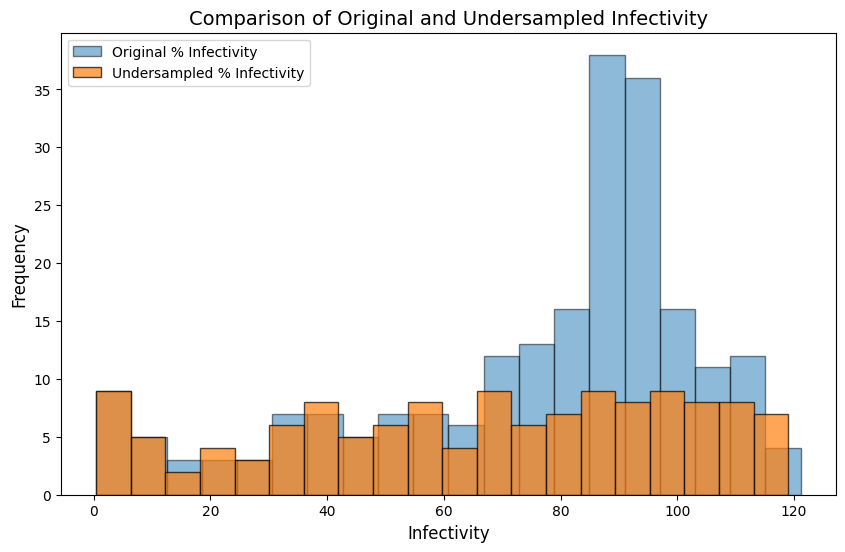

In [8]:
# Plot the histogram of the original data and the undersampled data together for visual comparison. Should have similar distribution
# across the range.
plt.figure(figsize=(10, 6))
plt.hist(polym_df['% Infectivity'], bins=20, alpha=0.5, label='Original % Infectivity', edgecolor='black')
plt.hist(undersampled_df['% Infectivity'], bins=20, alpha=0.7, label='Undersampled % Infectivity', edgecolor='black')

# Adding labels and title
plt.title('Comparison of Original and Undersampled Infectivity', fontsize=14)
plt.xlabel('Infectivity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adding a legend to differentiate the histograms
plt.legend()


# Show the plot
plt.show()


In [9]:
#Reset polym_df after undersampling, just so I didn't have to change code below.
polym_df = undersampled_df

## Calculate copolymer descriptors

In [10]:
"""
Import monomer descriptors
Monomer descriptors which are prepared independently using preferred descriptor library, for example RDKit or Mordred.
Add a name for the desc_pkg variable to amend file names, to create unique outputs - images, csv, saved models, etc. Will allow you to 
use different predictors/features and compare model performance.
"""
desc_pkg = 'Mordred'
monomers = pd.read_excel('/Users/quynhnguyen/20241021_Mordred_new monomers.xlsx')

# Remove uncessary columns for model training or monomer definition.
monomers = monomers.drop(columns=['CAS'])
monomers = monomers.drop(columns=['SMILES'])

# Strip leading/trailing spaces from the 'Monomer' column
monomers['Monomer'] = monomers['Monomer'].str.strip()

monomers.tail()


,My classification,Monomer,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
134,Polar,"N,N-Dimethylmethacrylamide",module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,8.424292,2.135779,4.271558,8.424292,...,8.297793,35.071670,115.099714,5.480939,65,8,32,33,5.333333,1.888889
135,Polar,N-(Methoxymethyl)methacrylamide,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,10.175084,2.083968,4.167936,10.175084,...,8.094684,35.852159,131.094629,5.958847,102,8,34,34,4.972222,2.277778
136,Polar,N-(Hydroxymethyl)methacrylamide,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,8.647053,2.074313,4.148627,8.647053,...,8.011355,34.323564,117.078979,6.162052,70,7,30,30,4.722222,2.027778
137,Random,3-Methacrylamidophenylboronic Acid,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,17.75447,2.288246,4.576491,17.75447,...,9.259226,46.258171,207.106674,7.141609,390,19,70,77,6.805556,3.388889
138,Polar,n-Hydroxypropyl Methacrylate,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,11.239561,2.088622,4.177243,11.239561,...,8.168770,37.326413,146.094294,6.087262,143,9,38,38,5.222222,2.527778


In [11]:
# Step 1: Clean up descriptors to remove descriptors that have not been calculated correctly.

# Step 1: Remove columns where all values are 0
monomers_clean = monomers.loc[:, (monomers != 0).any(axis=0)]

# Step 2: Remove columns with any missing values
monomers_clean = monomers_clean.dropna(axis=1)

# Step 3: Remove columns where all values are the same
monomers_clean = monomers_clean.loc[:, (monomers_clean.nunique() > 1)]

# Step 4: Convert all columns except My Classification and Monomer 
# Replace non-numeric values with NaN
monomers_clean.iloc[:, 2:] = monomers_clean.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

# Step 5: Convert Boolean columns to integers if they exist
bool_columns = monomers_clean.select_dtypes(include='bool').columns
monomers_clean[bool_columns] = monomers_clean[bool_columns].astype(int)

# Step 6: Convert object columns to numeric if possible
object_columns = monomers_clean.select_dtypes(include='object').columns
monomers_clean[object_columns] = monomers_clean[object_columns].apply(pd.to_numeric, errors='coerce')

# Step 7: Delete all columns that still have NaN values
monomers_clean = monomers_clean.dropna(axis=1)

#Step 8: Add back in My Classification and Monomer columns
monomers_clean = pd.concat([monomers[['My classification']], monomers[['Monomer']], monomers_clean], axis=1)

# Display the cleaned DataFrame info and head
print("\nCleaned DataFrame Info:")
monomers_clean.info()
print("\nCleaned DataFrame Head:")
monomers_clean.head()



Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Columns: 794 entries, My classification to mZagreb2
dtypes: float64(637), int64(155), object(2)
memory usage: 862.4+ KB

Cleaned DataFrame Head:


,My classification,Monomer,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nBridgehead,nHetero,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,Hydrophobic,Methyl Methacrylate,0,0,0,0,17,7,0,2,...,0.000000,7.890957,32.688753,102.068080,6.004005,46,6,26,26,1.777778
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,0,0,0,0,39,17,4,3,...,0.000000,10.297184,51.266300,238.156895,6.106587,466,27,100,120,3.402778
2,Hydrophobic,Isobornyl Methacrylate,0,0,0,0,40,16,2,2,...,7.984463,10.161419,66.429498,224.177630,5.604441,407,27,90,112,3.298611
3,Hydrophobic,Butyl Methacrylate,0,0,0,0,26,10,0,2,...,0.000000,8.168770,37.326413,144.115030,5.542886,143,9,38,38,2.527778
4,Hydrophobic,Ethyl Methacrylate,0,0,0,0,20,8,0,2,...,0.000000,8.011355,34.323564,116.083730,5.804186,70,7,30,30,2.027778


In [12]:
"""
Calculate copolymer descriptors by performing dot product of monomer descriptors by molar composition of copolymers in the first DataFrame.
Treating copolymer features as the linear combiantion of the indivudal monomer components, without considering other polymer parameters, eg. MW, D(M).
Reference example of copolymer descriptor calculation: https://doi.org/10.1016/j.theochem.2006.04.018
"""
# Initialize an empty result DataFrame
result = pd.DataFrame()

# Set the monomers_clean index to 'Monomer' for easy access
monomers_indexed = monomers_clean.set_index('Monomer')

# Select only the descriptor columns for dot product calculation (excluding 'My classification' and 'Monomer')
descriptor_columns = monomers_indexed.columns[2:]  # Assuming the first column is 'My classification' and the second is 'Monomer'

# Iterate over each row (polymer) in polym_df
for index, polymer_row in polym_df.iterrows():
    # Select only the monomer columns defined in mono_head for the current polymer row
    selected_monomers = polymer_row[mono_head]

    # Get the corresponding descriptors for the selected monomers
    # This will only keep the descriptors of the monomers that are actually used in the polymer
    descriptors = monomers_indexed.loc[selected_monomers.index, descriptor_columns]

    # Ensure that the selected_monomers and descriptors are aligned
    # Perform the dot product, which will multiply proportions by descriptors
    polymer_descriptor = selected_monomers.dot(descriptors)

    # Convert the polymer_descriptor Series to DataFrame before concatenation
    polymer_descriptor_df = polymer_descriptor.to_frame().T  # Transpose to have it in the correct shape

    # Concatenate the result to the result DataFrame
    result = pd.concat([result, polymer_descriptor_df], ignore_index=True)

# Combine result_df with polym_df along the columns
polym_desc_df = pd.concat([polym_df.reset_index(drop=True), result.reset_index(drop=True)], axis=1)

# Display the resulting DataFrame
polym_desc_df.head()


,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,0.000000,38.559593,0.000000,33.886167,0.000000,0.000000,27.55424,0.000000,0.0,0.000000,...,0.0,877.963162,4464.582051,20993.064065,609.351128,45562.797981,1548.776553,6119.563812,6365.32544,354.349095
1,0.000000,9.590687,0.000000,0.000000,0.000000,36.074565,0.00000,54.334748,0.0,0.000000,...,0.0,870.653702,4332.532368,22472.917198,756.771426,70635205618.171829,1300.921191,5513.245857,5585.394988,314.595262
2,26.639950,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,54.146239,0.0,19.213811,...,0.0,887.483395,4663.222202,26548.513239,794.814798,70390173020.604706,1513.550189,6655.933436,6694.361059,364.244948
3,19.195268,0.000000,7.545013,0.000000,73.259720,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,844.30674,4177.61164,18930.460742,573.664616,41299.274146,1206.377231,5172.028363,5172.028363,317.162132
4,12.651781,0.000000,14.918967,0.000000,72.429253,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,844.226901,4176.775653,18867.594572,566.285733,40811.922258,1205.647013,5167.446556,5167.446556,317.117989


In [13]:
#Clean up polymer descriptors to remove descriptors that have not been calculated to a numerical value, are all blank, or all the same.

# Step 1: Remove columns where all values are 0
polym_desc_df = polym_desc_df.loc[:, (polym_desc_df != 0).any(axis=0)]

# Step 2: Remove columns with any missing values
polym_desc_df = polym_desc_df.dropna(axis=1)

# Step 3: Remove columns where all values are the same
polym_desc_df = polym_desc_df.loc[:, (polym_desc_df.nunique() > 1)]

# Save the new dataframe as an excel file, in case this is needed for future reference.
polym_desc_df.to_excel(f'{expt_name}_{desc_pkg}_copolymer descriptors.xlsx', index=None)

# Display the cleaned DataFrame info and head to check if columns were correctly removed
print("\nCleaned DataFrame Info:")
polym_desc_df.info()
print("\nCleaned DataFrame Head:")
polym_desc_df.head()



Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Columns: 688 entries, Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4) to mZagreb2
dtypes: float64(12), object(676)
memory usage: 704.3+ KB

Cleaned DataFrame Head:


,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,...,SRW08,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,0.000000,38.559593,0.000000,33.886167,0.000000,0.000000,27.55424,0.000000,0.0,0.000000,...,732.648617,877.963162,4464.582051,20993.064065,609.351128,45562.797981,1548.776553,6119.563812,6365.32544,354.349095
1,0.000000,9.590687,0.000000,0.000000,0.000000,36.074565,0.00000,54.334748,0.0,0.000000,...,725.64856,870.653702,4332.532368,22472.917198,756.771426,70635205618.171829,1300.921191,5513.245857,5585.394988,314.595262
2,26.639950,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,54.146239,0.0,19.213811,...,742.663342,887.483395,4663.222202,26548.513239,794.814798,70390173020.604706,1513.550189,6655.933436,6694.361059,364.244948
3,19.195268,0.000000,7.545013,0.000000,73.259720,0.000000,0.00000,0.000000,0.0,0.000000,...,704.282315,844.30674,4177.61164,18930.460742,573.664616,41299.274146,1206.377231,5172.028363,5172.028363,317.162132
4,12.651781,0.000000,14.918967,0.000000,72.429253,0.000000,0.00000,0.000000,0.0,0.000000,...,704.2213,844.226901,4176.775653,18867.594572,566.285733,40811.922258,1205.647013,5167.446556,5167.446556,317.117989


In [14]:
# Removes the monomer compositon columns and gives an overview of final dataframe for debugging
polym_desc_df = polym_desc_df.drop(columns=mono_head)
polym_desc_df.info()
polym_desc_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Columns: 678 entries, % Infectivity to mZagreb2
dtypes: float64(2), object(676)
memory usage: 694.0+ KB


,% Infectivity,SD % infectivity,Auto Sample ID,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nHetero,nH,...,SRW08,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,11.455522,2.289222,Polyethylene Glycol Monomethyl Ether Methacryl...,27.55424,203.317002,203.317002,3482.360642,1470.787259,343.233019,2011.573383,...,732.648617,877.963162,4464.582051,20993.064065,609.351128,45562.797981,1548.776553,6119.563812,6365.32544,354.349095
1,10.845824,2.773292,Polyethylene Glycol Monomethyl Ether Methacryl...,90.409313,0.0,0.0,3058.01951,1383.106808,536.520365,1674.912703,...,725.64856,870.653702,4332.532368,22472.917198,756.771426,70635205618.171829,1300.921191,5513.245857,5585.394988,314.595262
2,13.403339,7.994553,Polyethylene Glycol Monomethyl Ether Methacryl...,73.36005,0.0,0.0,3486.940076,1629.268805,692.573862,1857.67127,...,742.663342,887.483395,4663.222202,26548.513239,794.814798,70390173020.604706,1513.550189,6655.933436,6694.361059,364.244948
3,3.013782,2.015462,Polyethylene Glycol Monomethyl Ether Methacryl...,73.25972,0.0,0.0,3292.309833,1306.377231,350.04079,1985.932602,...,704.282315,844.30674,4177.61164,18930.460742,573.664616,41299.274146,1206.377231,5172.028363,5172.028363,317.162132
4,1.153462,0.029044,Polyethylene Glycol Monomethyl Ether Methacryl...,72.429253,0.0,0.0,3343.297538,1305.647013,323.036376,2037.650526,...,704.2213,844.226901,4176.775653,18867.594572,566.285733,40811.922258,1205.647013,5167.446556,5167.446556,317.117989


## Feature Reduction

In [15]:
"""
Set up test-train splits. When using RFECV, model training and hyperparameter tuning, need to split data before doing feature selection using the model, 
to prevent data leakage to the model.
"""
# Setup groups to ensure any duplicate compositions are not in train and test, to avoid data leakage
groups = polym_desc_df['Auto Sample ID']

# Define features to train (X) and output to predict (y)
X = polym_desc_df.iloc[:, 3:]  # Dropping the first three columns which should be infectivity, SD infectivity and Auto Sample ID
y = polym_desc_df['% Infectivity']  # Extracting the infectivity column
alpha = polym_desc_df['SD % infectivity']  # Extracting the SD infectivity column

# Setting up GroupShuffleSplit for test and train sets, to prevent data leakage.
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)  

# Perform the split
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Subset the data using train and test indices for this fold
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
alpha_train, alpha_test = alpha.iloc[train_idx], alpha.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

# Print the number of rows in train and test sets
print(f"Train set size: {len(train_idx)}, Test set size: {len(test_idx)}")

Train set size: 104, Test set size: 27


In [16]:
"""
Using the feature generation approach, there will be many more descriptors than are needed for the model. Need to reduce the number of features to 
simplify and speed up training of the model.
Firstly we conduct simple univariate feture selection, to see how each feature correlates with the output variable (Infectivity) alone. This is a crude
estimation, but we can quickly remove features that have no effect.
We then conduct Recursive Feature Reduction, which looks to see how the model performance scales with a reducing number of features. This is a slow
process, as it compares recursively fits the features to the model, then removes the lowest performing feature, and repeats.
This is why we do univariate feature selection first, to reduce time on this step.
"""

# Use univariate feature selection to reduce the number of features
selector = SelectKBest(score_func=f_regression, k=200)  # Select the top 200 features (tune k based on your data)
X_reduced = selector.fit_transform(X_train, y_train) # Using train split to prevent leakage to model. Likely not a big problem here, but more important for RFECV

# Get the selected feature names
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected Features after SelectKBest:", selected_feature_names)

Selected Features after SelectKBest: Index(['nBase', 'nAtom', 'nHeavyAtom', 'nC', 'nN', 'nO', 'ATS0dv', 'ATS1dv',
       'ATS3dv', 'ATS4dv',
       ...
       'MWC03', 'TMWC10', 'SRW02', 'SRW04', 'TSRW10', 'MW', 'WPol', 'Zagreb1',
       'Zagreb2', 'mZagreb2'],
      dtype='object', length=200)


In [17]:
%%time
#Slower Recursive Feature Elimination with Cross Fold Validation, to find minimum number of features.

# Define the variables from the dataframe using the reduced feature from univariate feature analysis (SelectKBest)
X_reduced = X_train.iloc[:, selected_feature_indices]  #Selecting only the reduced features from univariate feature selection above

# Create an instance of GroupKFold with the desired number of splits. Prevents leakage between folds.
gkf = GroupKFold(n_splits=5)

# Initiate model you want to use for RFECV. Currently using GBR as it performs very well on antiviral descriptor dataset.
model = GradientBoostingRegressor(random_state=42)  #It is not necessary to scale data for Gradient Boosting Regressor, so will skip scaling here.

# Create an RFECV instance
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=gkf,  # Use the previously defined GroupKFold
    scoring="r2",
    min_features_to_select=1,
    n_jobs=-1 # n_jobs=-1 uses all available CPU cores
)

# Fit RFECV with the raw data (without scaling) and groups. Only fits to training data set, to prevent leakage of data from test set.
rfecv.fit(X_reduced, y_train, groups=groups_train)

# Get the boolean mask of selected features
selected_features = rfecv.support_

# Get the names of the selected features if you have feature names available
selected_feature_names = X_reduced.columns[selected_features]
print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected Features:", selected_feature_names)


Optimal number of features: 73
Selected Features: Index(['nBase', 'ATS4dv', 'ATS1d', 'ATS5Z', 'ATS3m', 'ATS8m', 'ATS8v', 'ATS1p',
       'AATS3dv', 'AATS4dv', 'AATS2se', 'AATS3pe', 'AATS1are', 'AATS3p',
       'AATS4p', 'AATS3i', 'AATS4i', 'ATSC6d', 'ATSC8m', 'ATSC0pe', 'ATSC0are',
       'ATSC6are', 'ATSC6i', 'ATSC8i', 'AATSC2d', 'AATSC3i', 'MATS4d',
       'MATS2v', 'MATS4v', 'MATS2se', 'MATS4se', 'MATS2are', 'MATS2p',
       'MATS3p', 'MATS4p', 'MATS2i', 'MATS4i', 'GATS1dv', 'GATS4d', 'GATS4pe',
       'GATS4are', 'C1SP3', 'Xp-1dv', 'AXp-2dv', 'Sv', 'Mse', 'NssCH2',
       'NsssN', 'NssO', 'MINsCH3', 'nHBAcc', 'IC4', 'TIC1', 'SIC2', 'CIC2',
       'GhoseFilter', 'FilterItLogS', 'VMcGowan', 'PEOE_VSA1', 'SMR_VSA3',
       'SlogP_VSA2', 'EState_VSA6', 'MPC8', 'piPC8', 'GGI8', 'JGI5', 'JGI6',
       'JGI8', 'JGI9', 'JGI10', 'JGT10', 'MWC03', 'TSRW10'],
      dtype='object')
CPU times: user 40.1 s, sys: 122 ms, total: 40.2 s
Wall time: 1min 20s


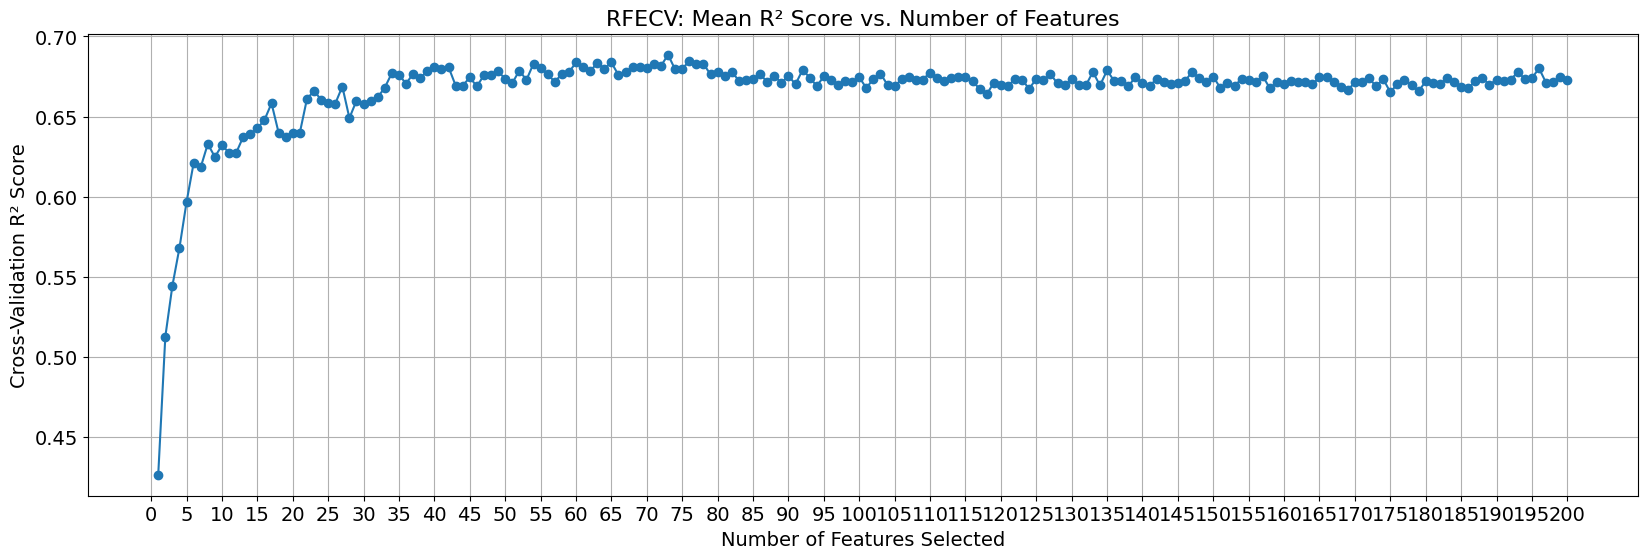

In [18]:
# Plotting the mean cross-validated score against the number of features
plt.figure(figsize=(20, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel('Number of Features Selected', fontsize=14)
plt.ylabel('Cross-Validation R² Score', fontsize = 14)
plt.title('RFECV: Mean R² Score vs. Number of Features', fontsize = 16)

plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
plt.xticks(range(0, len(rfecv.cv_results_['mean_test_score']) + 1, 5))  # X-ticks every 5
plt.grid(True)

# Save the plot as a TIFF file with 300 DPI resolution
plt.savefig(f'{expt_name}_{desc_pkg}_RFECV.tiff', format='tiff', dpi=300)  #first parameter defines the output filename, using some automated labesl from first cell

plt.show()


In [19]:
"""
You can manually override automated feature selection, and select your own number of highest ranked features. 
This is useful, as the automated process above will find the global maximum, without considering if within error of other values. You want to use
the smallest number of features that explains most of the variability in your dataset.
Using the ranking of features obtained from the RFECV process
"""
feature_ranking = rfecv.ranking_

# Ensure that feature_ranking and X.columns have the same length
print(f"Number of features in X: {len(X_reduced.columns)}")
print(f"Length of feature rankings: {len(feature_ranking)}")

# Select the top XX features based on their rankings. This enusres top XX features are selected, not top XX ranks (which can lead to more than 20 features)
top_n = 12
top_features_indices = np.argsort(feature_ranking)[:top_n]
selected_feature_names = X_reduced.columns[top_features_indices]

print("Top Features Selected:", selected_feature_names)

Number of features in X: 200
Length of feature rankings: 200
Top Features Selected: Index(['nBase', 'nHBAcc', 'AATSC2d', 'ATSC8i', 'IC4', 'ATSC6i', 'ATSC6are',
       'ATSC0are', 'ATSC0pe', 'MINsCH3', 'ATSC8m', 'SIC2'],
      dtype='object')


In [20]:
# Create a new DataFrame with only the selected features from recursive feature selection or manual selection above and save to a csv file.
select_feat_df = polym_desc_df[selected_feature_names]

# Add the target columns '% Infectivity', 'SD % infectivity' and 'Auto Sample ID' to the new DataFrame
select_feat_df.insert(0, '% Infectivity', polym_desc_df['% Infectivity'])
select_feat_df.insert(1, 'SD % infectivity', polym_desc_df['SD % infectivity'])
select_feat_df.insert(2, 'Auto Sample ID', polym_desc_df['Auto Sample ID'])

# Save to file
filename = f'{expt_name}_{desc_pkg}_selected_features.csv'  # Fixed the filename syntax
select_feat_df.to_csv(filename, index=False)  # Replace with the desired file name
print(f'{filename} has been written to CSV')

# Display the information and the first few rows of the updated DataFrame
select_feat_df.info()


20250107_antiviral polym_AL_Mordred_selected_features.csv has been written to CSV
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   % Infectivity     131 non-null    float64
 1   SD % infectivity  131 non-null    float64
 2   Auto Sample ID    131 non-null    object 
 3   nBase             131 non-null    object 
 4   nHBAcc            131 non-null    object 
 5   AATSC2d           131 non-null    object 
 6   ATSC8i            131 non-null    object 
 7   IC4               131 non-null    object 
 8   ATSC6i            131 non-null    object 
 9   ATSC6are          131 non-null    object 
 10  ATSC0are          131 non-null    object 
 11  ATSC0pe           131 non-null    object 
 12  MINsCH3           131 non-null    object 
 13  ATSC8m            131 non-null    object 
 14  SIC2              131 non-null    object 
dtypes: float6

## Machine learning on selected copolymer chemical features

In [3]:
"""
Load in selected features as a csv, so that you don't have to keep repeating feature selection when reloading your kernel. 
Automatically uses filename created above, or can manually change to another file if desired. 
Creates a list of selected feature names needed later for feature importance and SHAP analysis.
"""
# select_feat_df = pd.read_csv(filename)  # Uses automatically defined filename from above.
select_feat_df = pd.read_csv('20250107_antiviral polym_AL_Mordred_selected_features.csv')  # Manually define filename by copying from above. Useful when restarting kernel.

# Create the list of selected features, excluding the first three columns
selected_feature_names = list(select_feat_df.columns[3:])
groups = select_feat_df['Auto Sample ID']

X = select_feat_df.iloc[:, 3:]  # Dropping the first three columns which should be infectivity, SD infectivity and Auto Sample ID
y = select_feat_df['% Infectivity']
alpha = select_feat_df['SD % infectivity'] 

gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)  
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Reset X_train and X_test to only include the selected features
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]
alpha_train, alpha_test = alpha.iloc[train_idx], alpha.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

print('X: ', X)
print('X_train: ', X_train)
print('X_test: ', X_test)
print('y: ', y)
print('y_train: ', y_train)
print('y_test: ', y_test)
select_feat_df.info()


X:           nBase      nHBAcc    AATSC2d       ATSC8i         IC4       ATSC6i  \
0    27.554240  343.233019  -8.904376  -396.591256  386.472731  1422.257494   
1    90.409313  427.850869  -9.202612  -823.051586  377.315624   279.097651   
2    73.360050  545.853761 -10.061880  -507.196356  388.273977  -576.986988   
3    73.259720  350.040790 -10.735700 -1686.797741  355.034649  -774.757134   
4    72.429253  323.036376 -10.650572 -1682.836796  355.993127  -814.114979   
..         ...         ...        ...          ...         ...          ...   
126   6.772722  534.251005  -7.114488   107.639898  387.832272   830.394961   
127   6.861545  567.908706  -7.165482   126.590958  387.153524   896.979794   
128   0.000000  531.100083  -7.015428   157.014992  391.621407   590.672949   
129  12.331909  527.084152  -7.190827   -36.574711  387.827447   651.425208   
130   0.000000  588.260603  -7.099929   190.340003  390.551778   698.546484   

       ATSC6are    ATSC0are     ATSC0pe     MIN

In [22]:
# """
# Load in selected features as a csv, so that you don't have to keep repeating feature selection when reloading your kernel. 
# Automatically uses filename created above, or can manually change to another file if desired. 
# Creates a list of selected feature names needed later for feature importance and SHAP analysis.
# """
# # select_feat_df = pd.read_csv(filename)  # Uses automatically defined filename from above.

# select_feat_df = pd.read_csv('20250107_antiviral polym_AL_Mordred_selected_features.csv')  # Manually define filename by copying from above. Useful when restarting kernel.

# # Create the list of selected features, excluding the first three columns
# selected_feature_names = list(select_feat_df.columns[3:])

# # Reset X_train and X_test to only include the selected features
# X_train = X_train[selected_feature_names]
# X_test = X_test[selected_feature_names]

# print('Selected features are: ', selected_feature_names)
# select_feat_df.info()


Selected features are:  ['nBase', 'nHBAcc', 'AATSC2d', 'ATSC8i', 'IC4', 'ATSC6i', 'ATSC6are', 'ATSC0are', 'ATSC0pe', 'MINsCH3', 'ATSC8m', 'SIC2']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   % Infectivity     131 non-null    float64
 1   SD % infectivity  131 non-null    float64
 2   Auto Sample ID    131 non-null    object 
 3   nBase             131 non-null    float64
 4   nHBAcc            131 non-null    float64
 5   AATSC2d           131 non-null    float64
 6   ATSC8i            131 non-null    float64
 7   IC4               131 non-null    float64
 8   ATSC6i            131 non-null    float64
 9   ATSC6are          131 non-null    float64
 10  ATSC0are          131 non-null    float64
 11  ATSC0pe           131 non-null    float64
 12  MINsCH3           131 non-null    float64
 13  ATSC8m            131 non-null    float

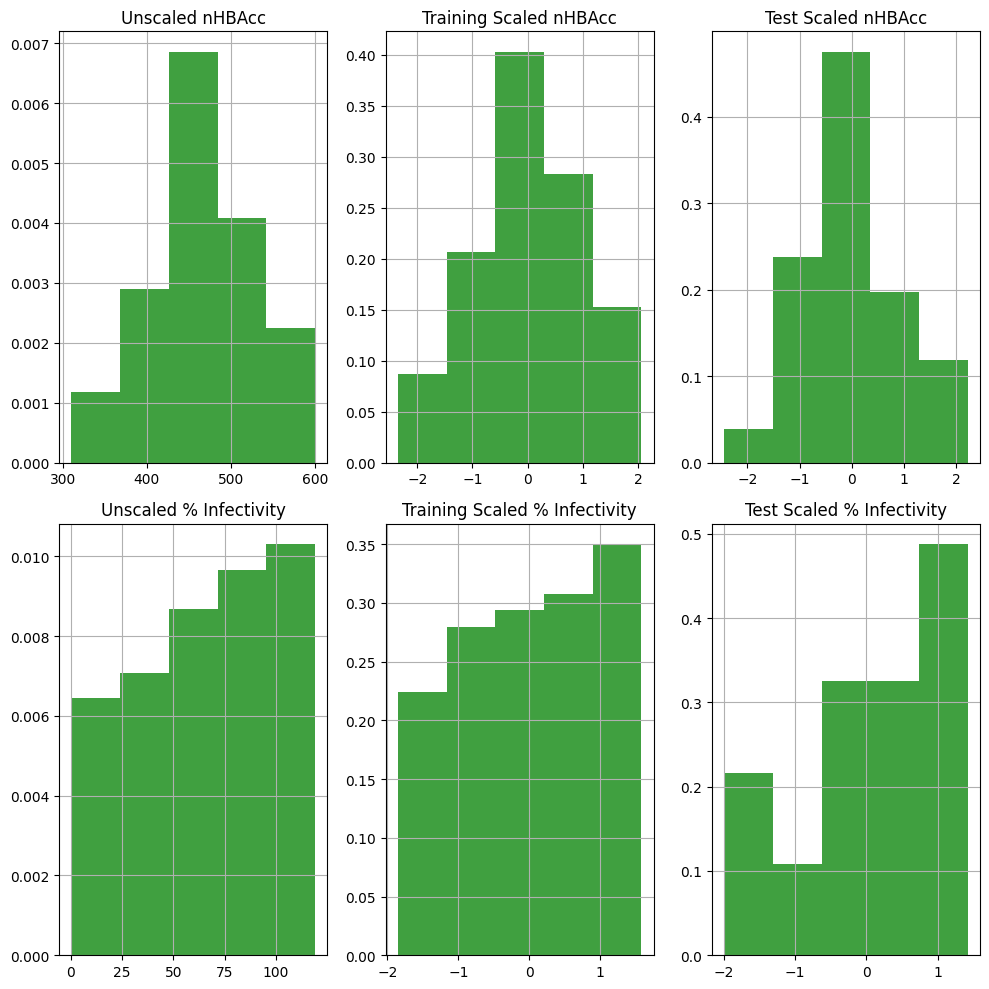

In [4]:
"""
Define X, y and alpha (Standard deviation) variables for the dataset, then scale each of these. The scaling is used in model development on existing
data, but the same scaler has to be applied to predicted data. So you need to run this cell if performing the active learning section below.
Data is scaled to reduce effect of different monomers having higher value ranges for compositions, or different features having wider ranges.
This is more or less important for different models. Should check effect of scaling on different models.
Will generate a couple of plots for quick validation that scaling has been performed correctly.
"""

# Define scalers for each variable
X_scaler = StandardScaler()
y_scaler = StandardScaler()
alpha_scaler = StandardScaler()

# Scale each variable
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.fit_transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Reshape for scaling and flatten back
y_test_scaled = y_scaler.fit_transform(y_test.values.reshape(-1, 1)).flatten()  # Reshape for scaling and flatten back
alpha_train_scaled = alpha_scaler.fit_transform(alpha_train.values.reshape(-1, 1)).flatten()
alpha_test_scaled = alpha_scaler.fit_transform(alpha_test.values.reshape(-1, 1)).flatten()

# Create the new DataFrame with specified columns
# Get Auto Sample ID from polym_desc_df (ensure polym_desc_df exists and is defined)
auto_sample_id = select_feat_df['Auto Sample ID'].values  # Ensure you get it from the correct DataFrame

# Combine scaled values into new DataFrames
transformed_train = pd.DataFrame(X_train_scaled)  # Start with X scaled values
transformed_train.insert(0, 'SD Infectivity', alpha_train_scaled)  # Insert alpha in column 1
transformed_train.insert(0, 'Infectivity', y_train_scaled)  # Insert y in column 0
transformed_train.insert(2, 'Auto Sample ID', groups_train.values)  # Insert Auto Sample ID in column 2

transformed_test = pd.DataFrame(X_test_scaled)  # Start with X scaled values
transformed_test.insert(0, 'SD Infectivity', alpha_test_scaled)  # Insert alpha in column 1
transformed_test.insert(0, 'Infectivity', y_test_scaled)  # Insert y in column 0
transformed_test.insert(2, 'Auto Sample ID', groups_test.values)  # Insert Auto Sample ID in column 2

#Visualisation to check scaling of monomers and infectivity
# Visualization: Create a 3x2 grid for the histograms
fig, axs = plt.subplots(2, 3, figsize=(10, 10))  # Adjust the figure size as needed

# Unscaled Descriptor Histogram (axs[X, y] defines which graph to plot onto the grid.
axs[0, 0].hist(select_feat_df.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 0].grid(True)
axs[0, 0].set_title('Unscaled ' + select_feat_df.iloc[:, 4].name)

# Scaled Descriptor Histogram
axs[0, 1].hist(transformed_train.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 1].grid(True)
axs[0, 1].set_title('Training Scaled ' + select_feat_df.iloc[:, 4].name)

# Scaled Descriptor Histogram
axs[0, 2].hist(transformed_test.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 2].grid(True)
axs[0, 2].set_title('Test Scaled ' + select_feat_df.iloc[:, 4].name)

# Unscaled Infectivity Histogram
axs[1, 0].hist(select_feat_df.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 0].grid(True)
axs[1, 0].set_title('Unscaled ' + select_feat_df.iloc[:, 0].name)

# Scaled Infectivity Histogram
axs[1, 1].hist(transformed_train.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 1].grid(True)
axs[1, 1].set_title('Training Scaled ' + select_feat_df.iloc[:, 0].name)

# Scaled Infectivity Histogram
axs[1, 2].hist(transformed_test.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 2].grid(True)
axs[1, 2].set_title('Test Scaled ' + select_feat_df.iloc[:, 0].name)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [5]:
"""
Initialize models from scikitlearn and define them in a dictionary, to make them easier to call and use later
"""
models_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'Stochastic Gradient Regression': SGDRegressor(),
    'K Neighbors Regression': KNeighborsRegressor(),
    'Elastic Net Regression': ElasticNet(random_state=42),
    'Adaptive Boosted Tree Regression': AdaBoostRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
}

In [6]:
%%time
"""
Trains and tests a range of standard models from scikit.learn, so you can see how different models perform on the dataset.
These mdoels are not optimised. That is achieved by tuning hyperparameters for each independent model. This is a slow process, so this quick fit
lets you determine what models are worth training.
"""

# Setup groups to prevent duplicates in different folds, which will lead to data leakage.
groups = transformed_train['Auto Sample ID']

# Setting up GroupKFold for cross-validation -- 5 folds
gkf = GroupKFold(n_splits=3)  # We are using grouped K fold to avoid data leakage between folds

# For storing model performance
model_performance = {name: {'R2': [], 'MSE': [], 'Fold R2': []} for name in models_dict}

# Cross-validation loop
for train_idx, val_idx in gkf.split(X_train_scaled, y_train_scaled, groups=groups):
    # Splitting the data
    X_train_kf, X_val_kf = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_kf, y_val_kf = y_train_scaled[train_idx], y_train_scaled[val_idx]
    alpha_train_kf, alpha_val_kf = alpha_train_scaled[train_idx], y_train_scaled[val_idx]

    for name, model in models_dict.items():
        # Train the model
        model.fit(X_train_kf, y_train_kf)
        # Make predictions
        y_pred = model.predict(X_val_kf)
        # Calculate performance metrics
        r2 = r2_score(y_val_kf, y_pred)
        mse = mean_squared_error(y_val_kf, y_pred)
        
        # Store performance metrics
        model_performance[name]['R2'].append(r2)
        model_performance[name]['MSE'].append(mse)
        # Store R2 for this fold
        model_performance[name]['Fold R2'].append(r2)

# Calculate the average R2 and MSE for each model
for name in models_dict:
    avg_r2 = np.mean(model_performance[name]['R2'])
    avg_mse = np.mean(model_performance[name]['MSE'])
    model_performance[name] = {
        'Avg R2': avg_r2,
        'Avg MSE': avg_mse,
        'Fold R2': model_performance[name]['Fold R2']  # Keep Fold R2 for each fold
    }

# Convert the performance metrics into a DataFrame
model_performance_df = pd.DataFrame(model_performance).T

# If you want to expand Fold R2 into separate columns for each fold
fold_columns = {f'Fold R2 {i+1}': [] for i in range(gkf.n_splits)}
for name in models_dict:
    for i in range(gkf.n_splits):
        fold_columns[f'Fold R2 {i+1}'].append(model_performance[name]['Fold R2'][i])

# Create a DataFrame for fold R2 values
fold_r2_df = pd.DataFrame(fold_columns, index=model_performance_df.index)

# Concatenate the average metrics with fold metrics
final_performance_df = pd.concat([model_performance_df[['Avg R2', 'Avg MSE']], fold_r2_df], axis=1)

# Sort by Avg R2
sorted_final_performance_df = final_performance_df.sort_values(by='Avg R2', ascending=False)
sorted_final_performance_df


CPU times: user 589 ms, sys: 5.12 ms, total: 594 ms
Wall time: 598 ms


,Avg R2,Avg MSE,Fold R2 1,Fold R2 2,Fold R2 3,Fold R2 4
Support Vector Regressor,0.746402,0.245841,0.689181,0.692155,0.863671,0.740601
K Neighbors Regression,0.687375,0.302543,0.700840,0.518073,0.810048,0.720537
Random Forest Regression,0.67472,0.307485,0.673318,0.571912,0.741460,0.712191
Adaptive Boosted Tree Regression,0.649602,0.33024,0.653698,0.571795,0.736121,0.636796
Gradient Boosting Regression,0.626258,0.350721,0.579453,0.570528,0.679391,0.675659
Stochastic Gradient Regression,0.590403,0.370055,0.713950,0.510130,0.559037,0.578496
Ridge Regression,0.586839,0.37766,0.643787,0.521850,0.579782,0.601936
Linear Regression,0.564024,0.397916,0.629873,0.507176,0.561032,0.558015
Decision Tree Regression,0.440785,0.513517,0.443324,0.459906,0.489756,0.370155
Elastic Net Regression,0.153957,0.7594,0.293861,0.034423,-0.032351,0.319896


In [7]:
# Define the model you want to train and tune hyperparamters for. Use name from dictionary to call automatically
model_name = 'Gradient Boosting Regression'
model = models_dict[model_name]

In [27]:
# %%time
# """
# Each model above will have different hyperparameters that will need to be tuned. Need to check what is necessary for each model and update accordingly.
# This code tunes hyperparameters on a single split of data, then trains the model with GroupKFold CV.
# Not as robust as nested CV but faster for code development. Once happy can comment this cell out and use nested CV below.
# """
# # Create groups based on sample ID, to ensure duplicate compositions don't end up in test and train datasets. Prevents data leakage in the model.
# groups = transformed_train['Auto Sample ID']

# # GroupKFold for CV on training data
# gkf = GroupKFold(n_splits=3)

# # Define scoring metrics
# scoring = {
#     'r2': make_scorer(r2_score),
#     'mse': make_scorer(mean_squared_error, greater_is_better=False),  # Negative MSE
#     'mae': make_scorer(mean_absolute_error, greater_is_better=False)  # Negative MAE
# }

# # Define hyperparameter search space
# param_distributions = {
#     'n_estimators': [100, 300, 500, 800, 1000],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
#     'max_depth': [3, 4, 5, 6, 7, 8, 10],
#     'min_samples_split': [2, 5, 10, 15],
#     'min_samples_leaf': [1, 2, 4, 6, 8],
#     'subsample': [0.6, 0.8, 1.0],
#     'max_features': ['sqrt', 'log2', None]
# }

# # Perform Randomized Search using the existing train set
# model_RS = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_distributions,
#     n_iter=100, 
#     cv=gkf,  # Standard K-Fold for hyperparameter tuning (independent of the outer split)
#     random_state=42,
#     scoring=scoring,
#     refit='r2',  # Specify which metric to use for refitting
#     n_jobs=-1
# )

# # Fit RandomizedSearchCV on the existing training set
# model_RS.fit(X_train_scaled, y_train_scaled, groups=groups)

# # Get the best hyperparameters
# best_params = model_RS.best_params_
# print("Best Hyperparameters:", best_params)

# # Save cv_results for later use
# cv_results = pd.DataFrame(model_RS.cv_results_)

# # Train the final model using the best hyperparameters
# final_model = model.__class__(**best_params, random_state=42)  # Instantiate final model with best params

# # Get the best model 
# best_estimator = model_RS.best_estimator_

# # Evaluate the model using cross-validation with GroupKFold on the train set
# scores = cross_val_score(final_model, X_train_scaled, y_train_scaled, groups=groups, cv=gkf, scoring='r2')
# print("Cross-validated R2 scores with GroupKFold:", scores)
# print("Mean R2 score:", np.mean(scores))


In [8]:
%%time
"""
Each model above will have different hyperparameters that will need to be tuned. Need to check what is necessary for each model and update accordingly.
Nested cross-validation. We tune hyperparameters and train the model using each of the 5 folds in the dataset to improve robustness and 
generalizability of the model. Very high performance, but slow.
"""
# Create groups based on sample ID, to ensure duplicate compositions don't end up in test and train datasets. Prevents data leakage in the model.
groups = transformed_train['Auto Sample ID']

# GroupKFold for CV on training data
gkf = GroupKFold(n_splits=3)

# Define scoring metrics
scoring = {
    'r2': make_scorer(r2_score),
    'mse': make_scorer(mean_squared_error, greater_is_better=False),  # Negative MSE
    'mae': make_scorer(mean_absolute_error, greater_is_better=False)  # Negative MAE
}

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}
# Store performance across folds for final summary
outer_cv_scores = []

# Outer cross-validation loop
for train_idx, val_idx in gkf.split(X_train_scaled, y_train_scaled, groups=groups):
    
    # Define inner train and validation sets
    X_outer_train, X_outer_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_outer_train, y_outer_val = y_train_scaled[train_idx], y_train_scaled[val_idx]
    groups_outer_train = groups_train.iloc[train_idx]
    
    # Inner cross-validation for hyperparameter tuning
    model_RS = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=100,
        cv=gkf,  # Inner GroupKFold within outer fold
        random_state=42,
        scoring=scoring,
        refit='r2',
        n_jobs=-1
    )
    
    # Fit the inner RandomizedSearchCV on the current outer training fold
    model_RS.fit(X_outer_train, y_outer_train, groups=groups_outer_train)
    
    # Get the best model from inner CV
    final_model = model_RS.best_estimator_
    
    # Evaluate the best model on the outer validation set
    outer_r2 = r2_score(y_outer_val, final_model.predict(X_outer_val))
    outer_cv_scores.append(outer_r2)
    
    print(f"Outer Fold R2 Score: {outer_r2}")

# Get the best hyperparameters
best_params = model_RS.best_params_
print("Best Hyperparameters:", best_params)

# Final model performance summary
print("Nested CV Mean R2 Score:", np.mean(outer_cv_scores))
print("Nested CV R2 Scores across outer folds:", outer_cv_scores)

Outer Fold R2 Score: 0.7262300766717471
Outer Fold R2 Score: 0.611155604904934
Outer Fold R2 Score: 0.7390593613055901
Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.01}
Nested CV Mean R2 Score: 0.6921483476274237
Nested CV R2 Scores across outer folds: [0.7262300766717471, 0.611155604904934, 0.7390593613055901]
CPU times: user 643 ms, sys: 94 ms, total: 737 ms
Wall time: 10.3 s


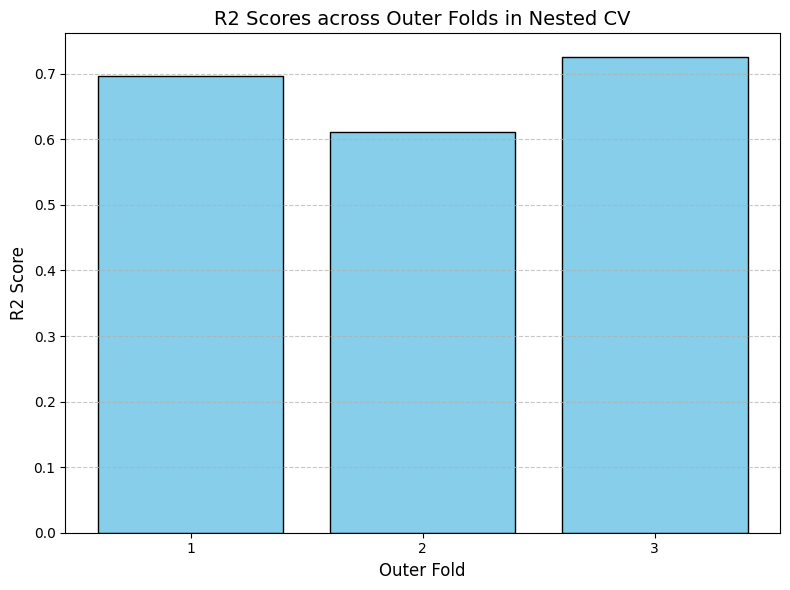

In [29]:
# Plotting the bar graph for outer_cv_scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(outer_cv_scores) + 1), outer_cv_scores, color='skyblue', edgecolor='black')

# Adding labels, title, and grid
plt.xlabel("Outer Fold", fontsize=12)
plt.ylabel("R2 Score", fontsize=12)
plt.title("R2 Scores across Outer Folds in Nested CV", fontsize=14)
plt.xticks(range(1, len(outer_cv_scores) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
# # Display the scores for each fold to evaluate performance of either CV approach.
# fold_columns = [col for col in cv_results.columns if 'split' in col and 'test' in col]

# # Display only the columns with scores for each fold
# fold_scores = cv_results[fold_columns]
# fold_scores


In [31]:
# """
# Visualise the performance of the model across folds using all three scoring parameters. It's not critical to have a model that performs
# extremely highly on any one split, rather a model that is generalizable - good performance across splits.
# """
# # Determine the number of folds based on the available columns in cv_results
# num_folds = sum('split' in col and 'test_r2' in col for col in outer_cv_results.columns)

# # Extract R2, MSE, and MAE for each fold for the best estimator
# r2_folds = cv_results.loc[model_RS.best_index_, [f'split{fold}_test_r2' for fold in range(num_folds)]]
# mse_folds = -cv_results.loc[model_RS.best_index_, [f'split{fold}_test_mse' for fold in range(num_folds)]]
# mae_folds = -cv_results.loc[model_RS.best_index_, [f'split{fold}_test_mae' for fold in range(num_folds)]]

# # Plot metrics for each fold
# plt.figure(figsize=(10, 12))

# # Plot R2 for each fold
# plt.subplot(3, 1, 1)
# sns.barplot(x=range(num_folds), y=r2_folds)
# plt.title('R² for Each Fold', fontsize=16)
# plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
# plt.xlabel('Fold Index', fontsize=14)
# plt.ylabel('R²', fontsize=14)

# # Plot MSE for each fold
# plt.subplot(3, 1, 2)
# sns.barplot(x=range(num_folds), y=mse_folds)
# plt.title('MSE for Each Fold', fontsize=16)
# plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
# plt.xlabel('Fold Index', fontsize=14)
# plt.ylabel('MSE', fontsize=14)

# # Plot MAE for each fold
# plt.subplot(3, 1, 3)
# sns.barplot(x=range(num_folds), y=mae_folds)
# plt.title('MAE for Each Fold', fontsize=16)
# plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
# plt.xlabel('Fold Index', fontsize=14)
# plt.ylabel('MAE', fontsize=14)

# plt.tight_layout()

# # Save the figure
# plt.savefig(f'{expt_name}_{desc_pkg}_{model_name}_CV.tiff', format='tiff', dpi=300)  # Define the output filename dynamically

# plt.show()


In [9]:
"""
Use trained model to predict on test set, to test performance of model
"""
# Make sure model is fit on entire training data set
final_model.fit(X_train_scaled, y_train_scaled)

# Predict on test data set and evaluate fit
predictions = final_model.predict(X_test_scaled) # Predictions made on the test set
mse_test = mean_squared_error(y_test_scaled, predictions) #Evaluation of MSE based on actual label (y_test) and predicted label
mae_test = mean_absolute_error(y_test_scaled, predictions) #Evaluation of MAE based on actual label (y_test) and predicted label
r2_test = r2_score(y_test_scaled, predictions) #Evaluation of r2 based on actual label (y_test) and predicted label
print('MSE on test set: ',mse_test)
print('MAE on test set: ',mae_test)
print('R2 on test set: ',r2_test )

MSE on test set:  0.41062865647473384
MAE on test set:  0.5252100757382088
R2 on test set:  0.5893713435252661


In [ ]:
#Unscale predicted data, and plot against original infectivity data (y)
predictions_unscaled = y_scaler.inverse_transform(predictions.reshape(-1,1))

plt.plot(y_test, predictions_unscaled, 'o')
plt.title(f'{model_name} Score: {round(r2_test, 2)} | MAE: {round(mae_test, 2)}', fontsize=16)
plt.xlabel('Actual Infectivity', fontsize = 14)
plt.ylabel('Predicted Infectivity', fontsize = 14)
plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
plt.plot([0,120],[0,120]) # draws a perfect correlation line for the fit, as a guide for the eye

# Use tight layout to avoid cutting off labels
plt.tight_layout()

# Save the plot as a tiff image at 300 dpi
plt.savefig(f'{expt_name}_{desc_pkg}_{model_name}_test fit.tiff', format='tiff', dpi=300)  #first parameter defines the output filename, using some automated labesl from first cell

plt.show()

In [ ]:
# #Predict model on entire dataset. Technically shouldn't really do this, as the model has already seen the test data. Can lead
# #to overfitting.
# predictions_all = final_model.predict(X_train_scaled) 
# mse_test = mean_squared_error(y_train_scaled, predictions_all) #Evaluation of MSE based on actual label (y_test) and predicted label
# mae_test = mean_absolute_error(y_train_scaled, predictions_all) #Evaluation of MAE based on actual label (y_test) and predicted label
# r2_test = r2_score(y_train_scaled, predictions_all) #Evaluation of r2 based on actual label (y_test) and predicted label
# print('MSE on test set: ',mse_test)
# print('MAE on test set: ', mae_test)
# print('R2 on test set: ', r2_test )

In [ ]:
# #Unscale predicted data, and plot against original infectivity data (y)
# predictions_all_unscaled = y_scaler.inverse_transform(predictions_all.reshape(-1,1))

# plt.plot(y_train,predictions_all_unscaled, 'o')
# plt.title(f'{model_name} Score: {round(r2_test, 2)} | MAE: {round(mae_test, 2)}', fontsize=16)
# plt.xlabel('Actual Infectivity', fontsize = 14)
# plt.ylabel('Predicted Infectivity', fontsize = 14)
# plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
# plt.plot([0,120],[0,120]) # draws a perfect correlation line for the fit, as a guide for the eye

# # Use tight layout to avoid cutting off labels
# plt.tight_layout()

# # Save the plot as a tiff image at 300 dpi
# plt.savefig(f'{expt_name}_{desc_pkg}_{model_name}_predict all.tiff', format='tiff', dpi=300)  #first parameter defines the output filename, using some automated labesl from first cell
# plt.show()

In [ ]:
"""
Histogram plot of feature importance for the model, ranked in order of importance.
"""
# Step 1: Extract Feature Importance
feature_importances = best_estimator.feature_importances_

# Check the length of feature_importances
print("Number of feature importances:", len(feature_importances))

importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': feature_importances  # Ensure this matches the selected features
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Step 3: Create a Horizontal Bar Plot
plt.figure(figsize=(10, 16))  # Set figure size
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red', edgecolor='black')

# Set title and labels
plt.title('Feature Importance for Selected Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Use tight layout to avoid cutting off labels
plt.tight_layout()

# Save the plot as a tiff image at 300 dpi 
plt.savefig(f'{expt_name}_{desc_pkg}_{model_name}_feature_importance.tiff', format='tiff', dpi=300)  #first parameter defines the output filename, using some automated labesl from first cell

# Show the plot
plt.show()
#Set up image

In [ ]:
"""
SHAP beeswarm plot, showing relative impact of each feature, and how it scales with feature.
"""
# Adjust the font sizes for the SHAP plot
plt.rc('font', size=14)              # Set the default text size for all elements
plt.rc('axes', titlesize=16)         # Set the font size of the axes titles
plt.rc('axes', labelsize=14)         # Set the font size of the x and y axis labels
plt.rc('xtick', labelsize=14)        # Set the font size of the tick labels on the x-axis
plt.rc('ytick', labelsize=14)        # Set the font size of the tick labels on the y-axis
plt.rc('legend', fontsize=14)        # Set the font size of the color bar (legend) labels

# Initialize the explainer with the best estimator

# Initialize the explainer with the best estimator
# Use the training data or the data used to calculate feature importances
explainer = shap.Explainer(best_estimator, X_train_scaled, feature_names=selected_feature_names)

# Calculate SHAP values for the same data used in training/testing
shap_vals = explainer(X_train_scaled)  # Ensure this data has the same shape as expected

# Create a new figure for the SHAP summary plot
plt.figure()

# Generate the SHAP summary plot
shap.summary_plot(shap_vals, show=False, max_display=50)  # Use show=False to prevent it from displaying immediately

# Save the SHAP summary plot as a tiff image at 300 DPI
plt.savefig(f'{expt_name}_{desc_pkg}_{model_name}_SHAP.tiff', format='tiff', dpi=300)  #first parameter defines the output filename, using some automated labesl from first cell

# Display the plot
plt.show()


In [ ]:
## Save trained model to a file, that can be imported and used later, without having to retrain the model.
joblib.dump(best_estimator, f'{expt_name}_{desc_pkg}_{model_name}.joblib')

## Prediction to new monomers and copolymers

Preparation of data and new copolymers to test

In [ ]:
# #Load model from a saved file, means you can start script from here, without doing training above. Need to update filename to correct model and descriptor list.
# best_estimator = joblib.load(f'{expt_name}_{desc_pkg}_{model_name}.joblib') # Automatically defined model from above 
# # best_estimator = joblib.load('20241021_antiviral polym_AL_Mordred_Gradient Boosting Regression.joblib') # Define saved model. 

In [ ]:
# """
# Create a dictionary for all monomers in the library, defining ranges for random number generator based on classification.
# You don't want to include 0 in the range, as zero for any given monomer is the same as not randomly sampling. Reduces the number of duplicates you create.
# You can manually define classification, or I want to try and do PCA/KNN analysis to identify monomer classes
# """
# # Define np.linspace values for each category
# category_values = {
#     'Polar': np.linspace(40, 100, 7).tolist(),
#     'Hydrophobic': np.linspace(10, 30, 3).tolist(),
#     'Ionic': np.linspace(10, 40, 4).tolist(),
#     'Fluorinated': np.linspace(10, 30, 3).tolist(),
#     'Random': np.linspace(10, 40, 4).tolist(),
#     'Cyclic sidechains': np.linspace(10, 40, 4).tolist(),
#     'Silicon': np.linspace(10, 30, 3).tolist(),
#     'Reactive Side Chains': np.linspace(10, 40, 4).tolist(),
# }

# # Create a dictionary where 'Monomer' is the key and includes classification and np.linspace values
# monomers_dict = {
#     monomer: {
#         'My classification': classification,
#         'range': category_values[classification]
#     }
#     for monomer, classification in zip(monomers_clean['Monomer'], monomers_clean['My classification'])
# }

# # Print the dictionary. Only use for debugging
# # print(monomers_dict)

In [ ]:
# %%time
# """
# Randomly generates all combinations, using only one polar monomer per combination. Will generate X combinations for each polar combination,
# and loop through polar monomers up to a set maximum. In the loop it checks if sum of monomers = 100, and only stores valid combinations.
# Will make lots of up duplicates of the same combo, that are filtered in cell below.
# 10,000 combinations takes ~3 mins, 20,000 takes ~6 mins.
# You need to adjust combinations_per_polar relative to max_combinations, to reach max_combinations, depending on number of polar monomers, and linear space created above.
# """
# # Filter monomers based on classification
# polar_monomers = {name: info for name, info in monomers_dict.items() if info['My classification'] == 'Polar'}
# not_polar_monomers = {name: info for name, info in monomers_dict.items() if info['My classification'] != 'Polar'}

# # Prepare to generate random combinations
# max_combinations = 10_000
# combinations_per_polar = 1000  
# total_combinations = 0
# combinations = []

# # Generate random combinations
# for polar_monomer in polar_monomers.keys():
#     current_polar_count = 0  # Track combinations for the current polar monomer
    
#     while total_combinations < max_combinations and current_polar_count < combinations_per_polar:
#         # Sample a random value from the current polar monomer's range
#         polar_range = polar_monomers[polar_monomer]['range']
#         polar_value = random.choice(polar_range)

#         # Choose random not-polar monomers
#         not_polar_keys = list(not_polar_monomers.keys())

#         # Sample a random number of not-polar monomers (including the case of selecting none)
#         num_not_polar = random.randint(0, len(not_polar_keys))
#         chosen_not_polars = random.sample(not_polar_keys, num_not_polar)

#         # Create a combination dictionary
#         combination = {polar_monomer: polar_value}  # Use the sampled value
#         for not_polar in chosen_not_polars:
#             not_polar_value = random.choice(not_polar_monomers[not_polar]['range'])
#             combination[not_polar] = not_polar_value  # Sample a random value for not-polar

#         # Check if the sum of values equals 100
#         if sum(combination.values()) == 100:
#             combinations.append(combination)  # Only add if the sum is 100
#             total_combinations += 1
#             current_polar_count += 1  # Increment count for the current polar monomer

#         # Check if we've reached the maximum limit
#         if total_combinations >= max_combinations:
#             break

# # Convert the list of combinations to a DataFrame for better visualization (optional)
# df_combinations = pd.DataFrame(combinations)

# # Create a list of all column headings from df_combinations to use later for filtering dataframes.
# new_mon_list = df_combinations.columns.tolist()

# # Display the first few rows and the total count of combinations
# print(f'Total combinations generated: {len(combinations)}')
# df_combinations.info()
# df_combinations.head()

In [ ]:
# # Remove duplicate compositions that are randomly generated.
# print("Original polymer library:", df_combinations.shape)
# df_combinations = df_combinations.drop_duplicates()
# print("Duplicates removed:", df_combinations.shape)

In [ ]:
# """
# Want to select copolymer compositions that are likely to be soluble. Analyse SLogP for the original copolymers, and use this as the range for new polymers.
# Transform the monomer features to use only the selected features from the trained model and include SLogP to predict solubility
# """
# new_monomers_select = monomers_clean.loc[:, selected_feature_names]
# new_monomers_select['SLogP'] = monomers_clean['SLogP'] #Keep SLogP to filter predicted polymers on likely solubility
# new_monomers_select.insert(0, 'Monomer', monomers_clean['Monomer'])
# new_monomers_select.info()
# new_monomers_select.head()

In [ ]:
# %%time
# """
# Calculate dot product between monomer features and predicted copolymer library, to determine copolymer features.
# """
# # Initialize an empty result DataFrame
# result = pd.DataFrame()

# # Set the index of new_monomers_select to 'Monomer' for easy access
# monomers_indexed = new_monomers_select.set_index('Monomer')

# # Check for duplicates in the index of monomers_indexed. 
# if monomers_indexed.index.duplicated().any():
#     print("Duplicates found in monomer descriptors. Dropping duplicates.")
#     # Drop duplicates, keeping the first occurrence
#     monomers_indexed = monomers_indexed[~monomers_indexed.index.duplicated(keep='first')]

# # Select descriptor columns 
# descriptor_columns = monomers_indexed.columns  # Includes all columns

# # Iterate over each polymer in df_combinations
# for _, polymer_row in df_combinations.iterrows():
#     # Directly select the monomer-related columns based on their names in the polymer_row
#     selected_monomers = polymer_row.dropna().astype(str).index  # Adjust as needed if you know specific monomer column names
    
#     # Get descriptors for the selected monomers, ensuring alignment
#     descriptors = monomers_indexed.loc[selected_monomers, descriptor_columns].fillna(0)

#     # Calculate the dot product with the polymer proportions
#     polymer_descriptor = polymer_row[selected_monomers].dot(descriptors)

#     # Append the resulting Series to the result DataFrame
#     result = pd.concat([result, polymer_descriptor.to_frame().T], ignore_index=True)

# # Concatenate results with df_combinations along the columns and drop rows that are duplicates.
# new_polym_desc_df = pd.concat([df_combinations.reset_index(drop=True), result.reset_index(drop=True)], axis=1)

# # Display the resulting DataFrame
# new_polym_desc_df.head()


In [ ]:
# #Determine SLogP limits for synthesised polymers and apply to predicted copolymers
# # Calculate statistics for the SLogP column
# mean_slogp = polym_desc_df['SLogP'].mean()
# std_slogp = polym_desc_df['SLogP'].std()
# min_slogp = polym_desc_df['SLogP'].min()
# max_slogp = polym_desc_df['SLogP'].max()

# # Print the results
# print('Statistics of SLogP for Synthesised Polymers:')
# print(f"Mean SLogP: {mean_slogp}")
# print(f"Standard Deviation SLogP: {std_slogp}")
# print(f"Minimum SLogP: {min_slogp}")
# print(f"Maximum SLogP: {max_slogp}")

# #Set a threshold to the maximun of SLogP to filter predicted polymers, so we don't make polymers that are likely very insoluble.
# thresh_SLogP = max_slogp + 10
# print(f'Setting threshold for predicted polymers SLogP to: ', thresh_SLogP)

# #Determine SLogP limits for predicted polymers
# # Calculate statistics for the SLogP column
# mean_slogp = new_polym_desc_df['SLogP'].mean()
# std_slogp = new_polym_desc_df['SLogP'].std()
# min_slogp = new_polym_desc_df['SLogP'].min()
# max_slogp = new_polym_desc_df['SLogP'].max()

# # Print the results
# print('Statistics of SLogP for Predicted Polymers:')
# print(f"Mean SLogP: {mean_slogp}")
# print(f"Standard Deviation SLogP: {std_slogp}")
# print(f"Minimum SLogP: {min_slogp}")
# print(f"Maximum SLogP: {max_slogp}")



In [ ]:
# # Before filtering
# print("Original polymer library:", new_polym_desc_df.shape)

# # Remove rows where SLogP is greater than thresh_SLogP
# new_polym_desc_df = new_polym_desc_df[new_polym_desc_df['SLogP'] <= thresh_SLogP]

# # After filtering
# print("Thresholded polymer library:", new_polym_desc_df.shape)

In [ ]:
# """
# Automatically generate copolymer labels from the predicted composition table, ignoring all values that are 0.
# Prepares final dataframe ready for predicting with trained model.
# """
# # Create an empty list to store the new sample IDs
# new_sample_ids = []

# # Get the columns in new_polym_desc_df that match those in df_combinations, so you ignore descriptors when making sample IDs
# matching_columns = [col for col in new_polym_desc_df.columns if col in df_combinations.columns]

# # Iterate through the DataFrame and create new sample IDs
# for index, row in new_polym_desc_df.iterrows():

#     sample_id_parts = []
    
#     # Iterate only through the matching columns
#     for column in matching_columns:
#         value = row[column]
        
#         # Check if the value is not NaN and not 0
#         if not pd.isna(value) and value != 0:
#             formatted_value = int(value) if float(value).is_integer() else value
#             sample_id_parts.append(f"{column}({formatted_value})")
    
#     # Generate sample ID or assign 'NoValidData'
#     if sample_id_parts:
#         sample_id = '-'.join(sample_id_parts)
#         new_sample_ids.append(sample_id)
#     else:
#         new_sample_ids.append('NoValidData')

# #Drops monomer and SLogP columns, so you only have columns from ML model and gives an overview of final dataframe for debugging
# new_polym_desc_df = new_polym_desc_df.drop(columns=df_combinations.columns)
# new_polym_desc_df = new_polym_desc_df.drop(columns='SLogP')
# new_polym_desc_df.info()
# new_polym_desc_df.head()

## Prediciton of new copolymers with trained ML model

In [ ]:
# """
# Need to use same scaler as for training the model. If you have restarted the kernel, find the scaler cell above and run again to reset scaler and 
# test and train sets.
# """
# standard_scaler = StandardScaler()
# ss_column_transformer = ColumnTransformer(transformers=[('standard_scaler', standard_scaler, new_polym_desc_df.columns)])
# transformed_df = standard_scaler.fit_transform(new_polym_desc_df)

# # Create a DataFrame with the transformed data and the original column names
# transformed = pd.DataFrame(transformed_df, columns=new_polym_desc_df.columns)


# #Visualisation to check scaling of monomers and infectivity
# # Create a 2x2 grid for the histograms
# fig, axs = plt.subplots(2, 2, figsize=(8, 7))  # Adjust the figsize as needed

# # Unscaled Histogram
# axs[0, 0].hist(new_polym_desc_df.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
# axs[0, 0].grid(True)
# axs[0, 0].set_title('Unscaled ' + new_polym_desc_df.iloc[:, 0].name)

# # Scaled Histogram
# axs[0, 1].hist(transformed_df[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
# axs[0, 1].grid(True)
# axs[0, 1].set_title('Scaled ' + new_polym_desc_df.iloc[:, 0].name)

# # Unscaled Histogram
# axs[1, 0].hist(new_polym_desc_df.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
# axs[1, 0].grid(True)
# axs[1, 0].set_title('Unscaled ' + new_polym_desc_df.iloc[:, 4].name)

# # Scaled Histogram
# axs[1, 1].hist(transformed_df[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
# axs[1, 1].grid(True)
# axs[1, 1].set_title('Scaled ' + new_polym_desc_df.iloc[:, 4].name)

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

In [ ]:
# """
# Use trained model to predict on the new predicted copolymer libaray
# """

# # Step 1: Make predictions on the test set
# predictions = best_estimator.predict(transformed_df)

# # Step 2: Inverse transform the predictions
# predictions_new = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()  # Directly flatten after inverse transform

# # Step 3: Create the final DataFrame
# final_df = pd.DataFrame({
#     'Predicted Infectivity': predictions_new,
#     'Copolymer Composition': new_sample_ids  # Ensure new_sample_ids is already a 1D array or list
# })

# # Calculate summary statistics of prediction. Useful for debugging and ensuring model is performing.
# min_value = final_df['Predicted Infectivity'].min()
# max_value = final_df['Predicted Infectivity'].max()
# mean_value = final_df['Predicted Infectivity'].mean()
# median_value = final_df['Predicted Infectivity'].median()

# # Print the summary statistics
# print("Summary Statistics for Predicted Infectivity:")
# print(f"Min: {min_value}")
# print(f"Max: {max_value}")
# print(f"Mean: {mean_value}")
# print(f"Median: {median_value}")

# # Display the final DataFrame
# final_df


In [ ]:
# # Plot a historgram of predicted values. Useful for checking model and library generation for debugging
# plt.figure(figsize=(8, 6))
# plt.hist(final_df['Predicted Infectivity'], bins=30, alpha=0.5, label='Predicted Infectivity', edgecolor='black')

# # Adding labels and title
# plt.title('Histogram of Predicted Infectivity')
# plt.xlabel('Infectivity')
# plt.ylabel('Frequency')

# # Adding a legend to differentiate between the histograms
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# # Rank the DataFrame by 'Predicted Infectivity' in ascending order
# ranked_df = final_df.sort_values(by='Predicted Infectivity', ascending=True)

# # Display the 20 lowest values
# lowest_values = ranked_df.head(30)

# print("20 Lowest Values for Predicted Infectivity:")
# lowest_values


## Estimating uncertainty for an EI approach in GBR
Many ML models like GBR do not estimate uncertainty of predictors. GPR is an exception, but did not perform well with this dataset.
Can use different approach to estimate uncertainty instead, by bootstrapping the model.

Approach comes from this publication: https://arxiv.org/abs/2205.11412

Github: https://github.com/jjbrophy47/ibug

Location:

    In IBUG, the location generally refers to the predicted output or mean value for the target variable given the input features.
    This is similar to the mean prediction from any regression model, where you expect the target variable to be around this value based on the model's learned patterns.

Scale:

    The scale output in IBUG represents the measure of uncertainty or variability around the predicted mean.
    It is typically derived from the instance-based nature of the model, which focuses on how closely instances (data points) in the training set resemble a given input. The scale can reflect the diversity of predictions based on the nearest neighbors or similar instances to the input data point.

In [ ]:
# # Fixes up issues with data formatting above, ready for ibug below. Only need to run once.
# # Convert transformed DataFrame to NumPy array
# transformed_np = transformed.values  # or transformed.to_numpy()


# # Ensure predictions is 1D if it's currently 2D
# if predictions.ndim > 1:
#     predictions = predictions.flatten()

In [ ]:
# %%time
# """
# Train the IBUG wrapper using your trained model from above (best_estimator) and your training and testing data. This trained wrapper
# can then predict infectivity and uncertainty of prediction. Note the predictions are scaled. 
# When I validated this, the scaled predicted infectivity from GBR and the ibug_infectivity were identical.
# """
# # Step 1: Fit the IBUGWrapper using the training dataset
# prob_model = IBUGWrapper().fit(
#     best_estimator,          # Your trained GBRT model
#     X_train_scaled,               # Training features (scaled)
#     y_train_scaled,               # Training target (scaled)
#     X_val=X_test_scaled,          # Testing dataset features for model training
#     y_val=y_test_scaled          # Predicted values for the training dataset
# )

# # Predict mean and variance for scaled features of new copolymer library
# location, scale = prob_model.pred_dist(transformed_np)

# print('Transformed shape: ', transformed.shape)
# print('Location shape: ', location.shape)
# print('Scale shape: ', scale.shape)

# # Assuming the number of rows in final_df matches the number of predictions in location and scale
# if len(final_df) == len(location) and len(final_df) == len(scale):
#     # Add the location and scale values as new columns to final_df
#     final_df['ibug_infectivity'] = location
#     final_df['ibug_uncertainty'] = scale
# else:
#     print("Warning: The number of rows in final_df does not match the length of location and scale predictions.")

# final_df.head()

In [ ]:
# """
# Create a scatter plot for predictions agaisnt uncertainty. Show distribution of predictions against the model, and how certain the model is of the prediction.
# This is key caclulating expected improvement and the explore-exploit tradeoff in AL (cell below).
# """
# plt.figure(figsize=(10, 6))
# plt.scatter(location, scale, alpha=0.6, edgecolors='w', s=100)
# plt.title('Scatter Plot of Predictions vs. Uncertainty')
# plt.xlabel('Predicted Values (Location)')
# plt.ylabel('Uncertainty (Scale)')
# plt.grid(True)

# # Show the plot
# plt.show()

In [ ]:
# """
# Calculate the Expected Improvement (EI) given the predicted values, the current best value, and an exploration-exploitation trade-off parameter (xi).
# High exploration: Set xi to a larger value like 0.1 or 0.5.
# High exploitation: Set xi to a small value like 0.01 or even 0.
# xi Value	Use Case	                                      Optimization Strategy
# ξ=0	        Late-stage optimization, focus on best regions	  Pure exploitation
# 0.01−0.1    Mid-stage optimization, moderate refinement	      Balanced exploitation-exploration
# 0.1−0.3	    Early-stage optimization, exploring new regions	  Focused exploration
# >0.3	    High uncertainty in model, very early stages	  Aggressive exploration

# Parameters:
# x (float): The candidate point.
# x_pred (numpy.ndarray): The array of predicted x values.
# y_pred (numpy.ndarray): The array of predicted y values.
# y_best (float): The current best y value.
# sigma (float): The standard deviation of the predicted y values.

# Returns:
# float: The Expected Improvement (EI) at the candidate point.
# """
# def expected_improvement(x, x_pred, y_pred, y_best, sigma, xi):
#     z = (y_best - y_pred - xi) / sigma  #for minmization task, it is best-pred. For maximisation it is pred-best.
#     ei = (y_best - y_pred - xi) * norm.cdf(z) + sigma * norm.pdf(z) #for minmization task, it is best-pred. For maximisation it is pred-best.
#     return ei

# # Decide on exploration vs exploitation trade off
# xi = 0.2

# # Find the best observed Infectivity
# y_best = location.min()

# # Calculate the Expected Improvement and add it to the dataframe
# final_df['EI'] = expected_improvement(location, y_train_scaled, location, y_best, scale, xi)  #At some point I need to work out why y_train_scaled is used here.
# final_df

In [ ]:
# """
# Sorting and extracing the samples with the greatest Expected Improvement.
# Will also plot these values on the scatter plot, so you can see how changing xi and explore-exploit tradeoff changes distribution in dataset.
# """
# final_df_sorted = final_df.sort_values(by='EI', ascending=False)

# #Set the number of predicted samples you want to shortlist
# shortlist = 200

# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(location, scale, alpha=0.6, edgecolors='w', s=100)

# # create an analogous scatterplot with the top  points from final_df_sorted
# plt.scatter(final_df_sorted['ibug_infectivity'].head(shortlist),final_df_sorted['ibug_uncertainty'].head(shortlist),color='red',edgecolor='k',zorder=2)

# plt.title('Scatter Plot of Predictions vs. Uncertainty')
# plt.xlabel('Predicted Values (Location)')
# plt.ylabel('Uncertainty (Scale)')
# plt.grid(True)

# # Show the plot
# plt.show()

In [ ]:
# # Extract the top copolymer compositions based on EI to an excel sheet for selecting experiments.
# top_compositions = final_df_sorted[['Copolymer Composition', 'Predicted Infectivity']].head(shortlist)

# # Save the new dataframe as an excel file
# top_compositions.to_excel(f'{expt_name}_{desc_pkg}_top predicted compositions.xlsx', index=None)

# # Display the results in a table format
# top_compositions
